###Fatima Munir 20L2133
###Muhammad Awais 20L2188
###Akbar Khan 20L2094

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##Augmentation

In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import cv2
from os import listdir
import time

%matplotlib inline
def augment_data(file_dir, n_generated_samples, save_to_dir):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  shear_range=0.1,
                                  brightness_range=(0.3, 1.0),
                                  horizontal_flip=True,
                                  vertical_flip=True,
                                  fill_mode='nearest'
                                 )

    for filename in listdir(file_dir):
        image = cv2.imread(file_dir + '/' + filename)
        image = image.reshape((1,) + image.shape)
        save_prefix = 'aug_' + filename[:-4]
        i = 0
        for batch in data_gen.flow(x=image, batch_size=1, save_to_dir=save_to_dir,
                                   save_prefix=save_prefix, save_format='jpg'):
            i += 1
            if i > n_generated_samples:
                break

yes_path = '/content/drive/My Drive/dataset/brain_tumor_dataset/yes'
no_path = '/content/drive/My Drive/dataset/brain_tumor_dataset/no'

# Path where augmented data will be saved in your Google Drive
augmented_data_path = '/content/drive/My Drive/dataset/brain_tumor_dataset/'

# Augment data for 'yes' and 'no' examples
augment_data(file_dir=yes_path, n_generated_samples=6, save_to_dir=augmented_data_path+'yes')
augment_data(file_dir=no_path, n_generated_samples=9, save_to_dir=augmented_data_path+'no')
print("Augmentation Done")

Augmentation Done


In [9]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.utils import shuffle
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
from os import listdir

%matplotlib inline

##Data Preparation & Preprocessing

In [4]:
def crop_brain_contour(image, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)


    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Original Image')

        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both',
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)

        plt.title('Cropped Image')

        plt.show()

    return new_image

##Convert Image to Jpeg

In [5]:
from PIL import Image

def convert_to_jpeg(input_image_path, output_image_path):
    try:
        bgr_image = cv2.imread(input_image_path)

        # Convert BGR to grayscale
        grayscale_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2GRAY)

        # Create a PIL Image object from the grayscale image array
        pil_image = Image.fromarray(grayscale_image)

        # Save the grayscale image in JPEG format
        pil_image.save(output_image_path, 'JPEG')
        print(f"Image converted to grayscale {output_image_path}")
    except Exception as e:
        print(f"Error: {e}")


##Load the data

In [7]:
def load_data(dir_list, image_size):
    # load all images in a directory
    X = []
    y = []
    image_width, image_height = image_size

    for directory in dir_list:
        for filename in listdir(directory):
            # load the image from Google Drive
            image = cv2.imread(directory + '/' + filename)
            # crop the brain and ignore the unnecessary rest part of the image
            image = crop_brain_contour(image, plot=False)
            # resize image
            image = cv2.resize(image, dsize=(image_width, image_height), interpolation=cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            # convert image to numpy array and append it to X
            X.append(image)
            # append a value of 1 to the target array if the image
            # is in the folder named 'yes', otherwise append 0.
            if directory.endswith('yes'):
                y.append([1])
            else:
                y.append([0])

    X = np.array(X)
    y = np.array(y)

    # Shuffle the data
    X, y = shuffle(X, y)
    return X, y

IMG_PATH = '/content/drive/My Drive/dataset/brain_tumor_dataset/'

augmented_yes = IMG_PATH + 'yes'
augmented_no = IMG_PATH + 'no'

IMG_WIDTH, IMG_HEIGHT = (240, 240)

X, y = load_data([augmented_yes, augmented_no], (IMG_WIDTH, IMG_HEIGHT))
print("Loading Done")


Loading Done


##Plot sample images

In [8]:
def plot_sample_images(X, y, n=50):
    for label in [0,1]:
        # grab the first n images with the corresponding y values equal to label
        images = X[np.argwhere(y == label)]
        n_images = images[:n]

        columns_n = 10
        rows_n = int(n/ columns_n)

        plt.figure(figsize=(20, 10))

        i = 1 # current plot
        for image in n_images:
            plt.subplot(rows_n, columns_n, i)
            plt.imshow(image[0])
            # remove ticks
            plt.tick_params(axis='both', which='both',
                            top=False, bottom=False, left=False, right=False,
                           labelbottom=False, labeltop=False, labelleft=False, labelright=False)

            i += 1

        label_to_str = lambda label: "Yes" if label == 1 else "No"
        plt.suptitle(f"Brain Tumor: {label_to_str(label)}")
        plt.show()

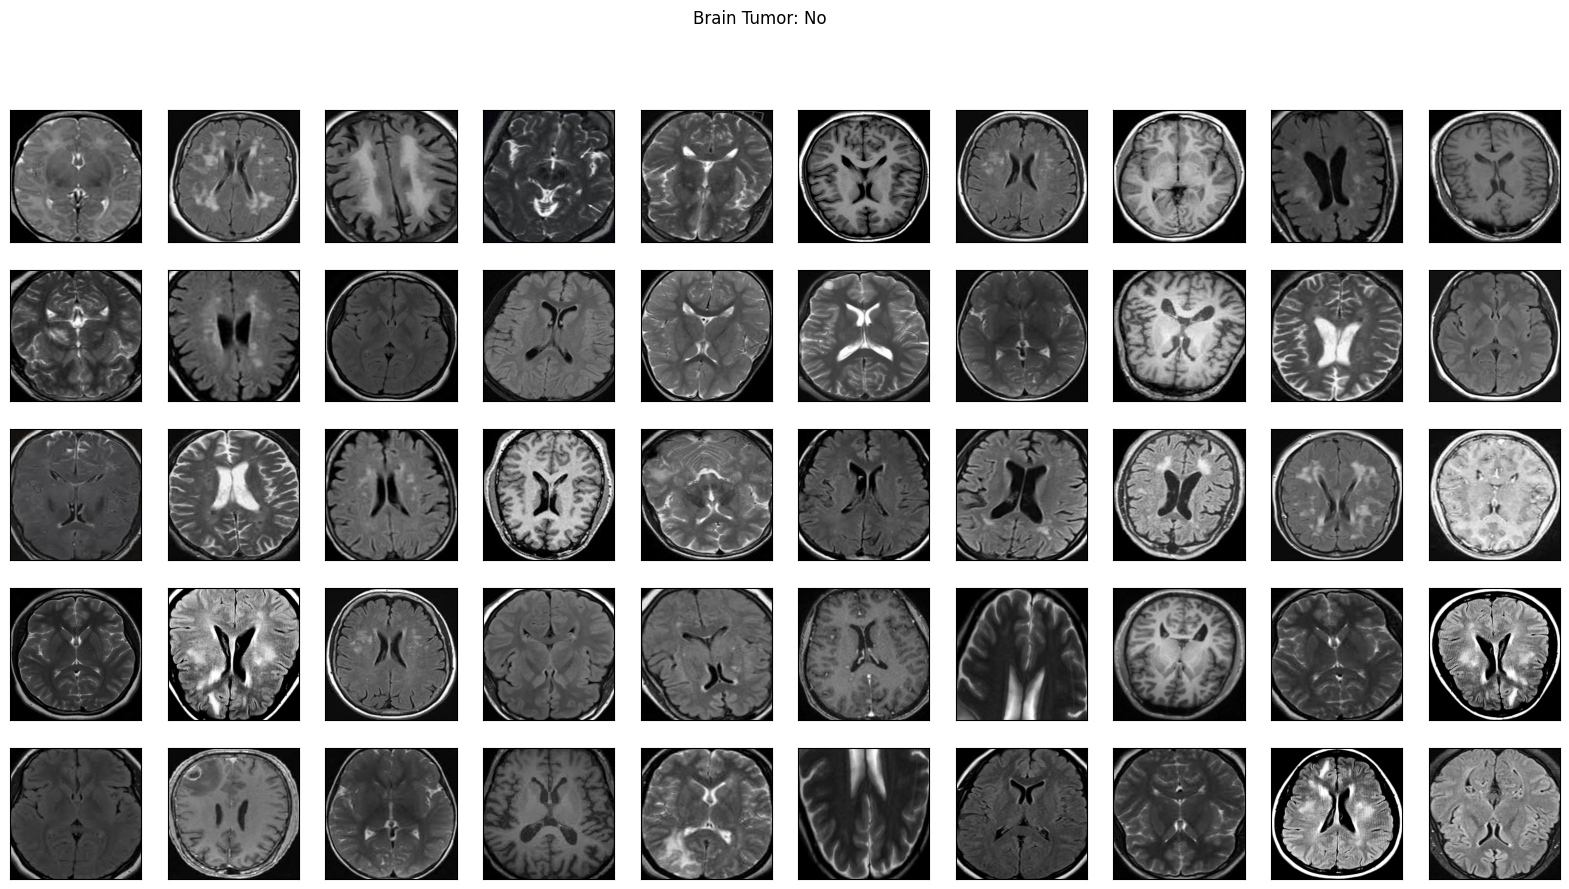

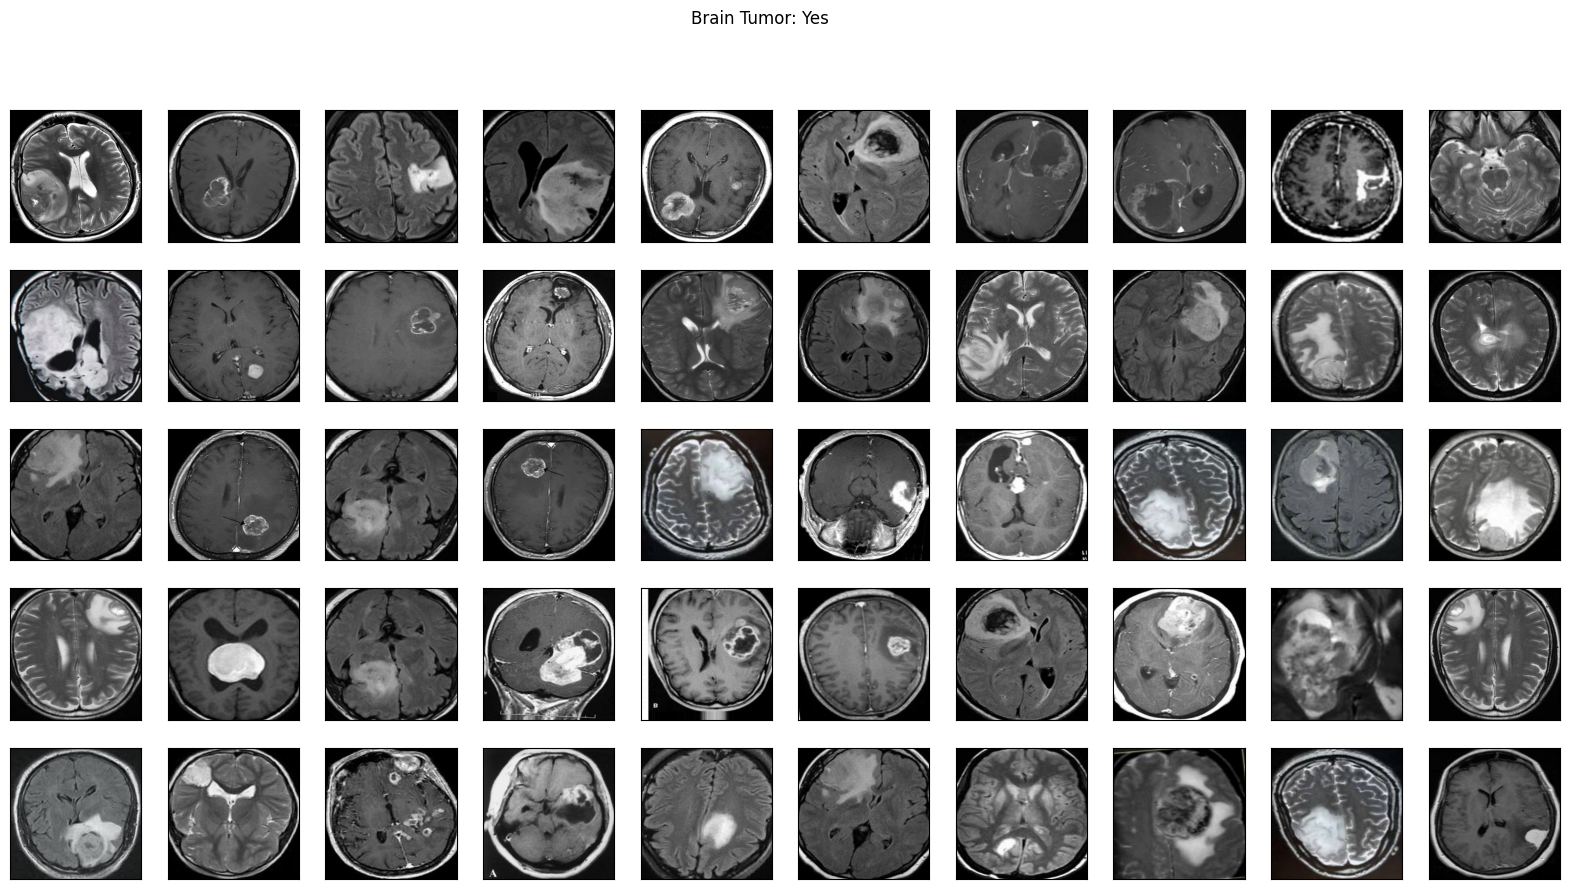

In [9]:
plot_sample_images(X, y)

##Split the Data

In [10]:
def split_data(X, y, test_size=0.2):
    X_train, X_test_val, y_train, y_test_val = train_test_split(X, y, test_size=test_size)
    X_test, X_val, y_test, y_val = train_test_split(X_test_val, y_test_val, test_size=0.5)

    return X_train, y_train, X_val, y_val, X_test, y_test

In [11]:
X_train, y_train, X_val, y_val, X_test, y_test = split_data(X, y, test_size=0.3)

In [12]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of development examples = " + str(X_val.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(y_train.shape))
print ("X_val (dev) shape: " + str(X_val.shape))
print ("Y_val (dev) shape: " + str(y_val.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(y_test.shape))

number of training examples = 1621
number of development examples = 348
number of test examples = 347
X_train shape: (1621, 240, 240, 3)
Y_train shape: (1621, 1)
X_val (dev) shape: (348, 240, 240, 3)
Y_val (dev) shape: (348, 1)
X_test shape: (347, 240, 240, 3)
Y_test shape: (347, 1)


In [13]:
def compute_f1_score(y_true, prob):
    y_pred = np.where(prob > 0.5, 1, 0)

    score = f1_score(y_true, y_pred)

    return score

##Build the model

In [14]:
def build_model(input_shape):
    X_input = Input(input_shape) # shape=(?, 240, 240, 3)

    # Zero-Padding: pads the border of X_input with zeroes
    X = ZeroPadding2D((2, 2))(X_input)

    X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = Activation('relu')(X) # shape=(?, 238, 238, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool0')(X) # shape=(?, 59, 59, 32)

    # MAXPOOL
    X = MaxPooling2D((4, 4), name='max_pool1')(X) # shape=(?, 14, 14, 32)

    # FLATTEN X
    X = Flatten()(X) # shape=(?, 6272)
    # FULLYCONNECTED
    X = Dense(1, activation='sigmoid', name='fc')(X) # shape=(?, 1)

    # Create model
    model = Model(inputs = X_input, outputs = X, name='BrainDetectionModel')

    return model

In [15]:
IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

In [16]:
model = build_model(IMG_SHAPE)

In [17]:
model.summary()

Model: "BrainDetectionModel"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 240, 240, 3)]     0         
                                                                 
 zero_padding2d (ZeroPaddin  (None, 244, 244, 3)       0         
 g2D)                                                            
                                                                 
 conv0 (Conv2D)              (None, 238, 238, 32)      4736      
                                                                 
 bn0 (BatchNormalization)    (None, 238, 238, 32)      128       
                                                                 
 activation (Activation)     (None, 238, 238, 32)      0         
                                                                 
 max_pool0 (MaxPooling2D)    (None, 59, 59, 32)        0         
                                               

###Compile model

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [23]:
# unique file name that will include the epoch and the validation accuracy
filepath="cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))


##Train the model

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

In [2]:
#Train more epochs
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=3, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

In [ ]:
model.fit(x=X_train, y=y_train, batch_size=32, epochs=5, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])

##Results

In [ ]:
#Load the best model
best_model = load_model(filepath='models/cnn-parameters-improvement-23-0.91.model')

In [8]:
best_model.metrics_names

['loss', 'acc']


In [7]:
#Accuracy of the best model on the testing data
loss, acc = best_model.evaluate(x=X_test, y=y_test)
print (f"Test Loss = {loss}")
print (f"Test Accuracy = {acc}")

Test Loss = 0.33390871454631127
Test Accuracy = 0.8870967741935484


In [6]:
#F1 score for the best model on the testing data:
y_test_prob = best_model.predict(X_test)
f1score = compute_f1_score(y_test, y_test_prob)
print(f"F1 score: {f1score}")

F1 score: 0.8829431438127091


In [5]:
#f1 score on the validation data
y_val_prob = best_model.predict(X_val)
f1score_val = compute_f1_score(y_val, y_val_prob)
print(f"F1 score: {f1score_val}")

F1 score: 0.9123867069486403
